<h1>Polynomial Regression</h1>
<p>
    Models are generated using <a href="https://scikit-learn.org/stable/" target="_blank">scikit-learn.</a>
    <br/><br/>
    Polynomial regression essentially tries to draw a line of best fit over the training dataset; it then uses the line to predict datapoints.
</p>

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as ma

%matplotlib inline

In [10]:
def get_csv(path: str) -> pd.DataFrame:
    
    df = pd.read_csv(path, parse_dates = ['Date'])\
        .drop(columns = ['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'])\
        .rename(columns = {'Date': 'date', 'Closing Price (USD)': 'price'})

    return df


def MAPE(pred, real) -> float:
    return np.mean(abs(1 - (pred / real)))


def RMSE(pred, real) -> float:
    return np.sqrt(np.mean((real - pred) ** 2))
    

def MSE(pred, real) -> float:
    return np.mean((real - pred) ** 2)


def plot_graph(*args, title: str = None, colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'], **kwargs) -> None:

    plt.figure(figsize = (20, 6))
    number_of_graph = 0
    
    if title is not None:
        plt.title(title)

    for arg in args:
        plt.plot(arg, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    for kw in kwargs:
        plt.plot(kwargs[kw], label = kw, color = colors[number_of_graph % len(colors)])
        number_of_graph += 1

    if len(kwargs) > 0:
        plt.legend(loc = 'best')

    plt.show()

In [11]:
df_ada = get_csv('./data/cardano.csv')

<h3>Splitting Data</h3>
<p>
    To test the polynomial model, the dataset will be split into a 70:30 train test ratio. For the independent variable the index will be used, and the price will be the dependent variable.
</p>

In [12]:
x_train_ada = df_ada.index[:ma.floor(df_ada.shape[0] * 0.7)]
y_train_ada = df_ada['price'][:ma.floor(df_ada.shape[0] * 0.7)]
x_test_ada = df_ada.index[ma.floor(df_ada.shape[0] * 0.7):]
y_test_ada = df_ada['price'][ma.floor(df_ada.shape[0] * 0.7):]

<h3>Transforming Data</h3>
<p>
    Before the mode can be fitted (trained), the independent variables must be transformed using a method in the PolynomialFeatures class provided by the scikit-learn library with the desired degree, which will be demostrated below.
</p>

In [68]:
polynomial_features = PolynomialFeatures(degree = 3)
x_train_ada_transformed = polynomial_features.fit_transform(x_train_ada.to_numpy()[:, None])
x_test_ada_transformed = polynomial_features.fit_transform(x_test_ada.to_numpy()[:, None])

In [69]:
model_ada = LinearRegression()
model_ada.fit(x_train_ada_transformed, y_train_ada)
ada_pred = model_ada.predict(x_test_ada_transformed)

Mean absolute percentage error: 97.66963888270874 %


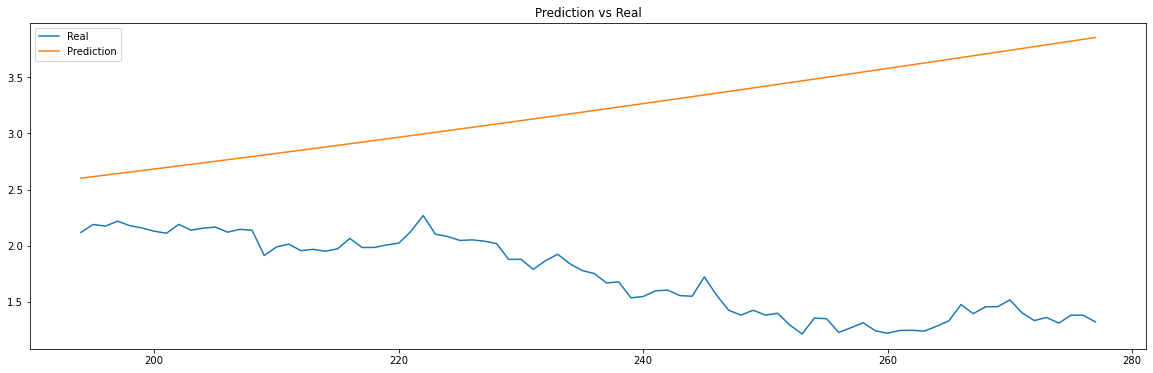

In [70]:
print('Mean absolute percentage error:', MAPE(ada_pred, y_test_ada) * 100, '%')
plot_graph(title = 'Prediction vs Real', Real = y_test_ada, Prediction = pd.Series(ada_pred, index = y_test_ada.index))

<h3>Visualising the Regression Line/Curve</h3>
<p>
    The prediction cuve is another word for line of best fit, to visualise the curve, let the model predict the whole unsplitted dataset.
</p>

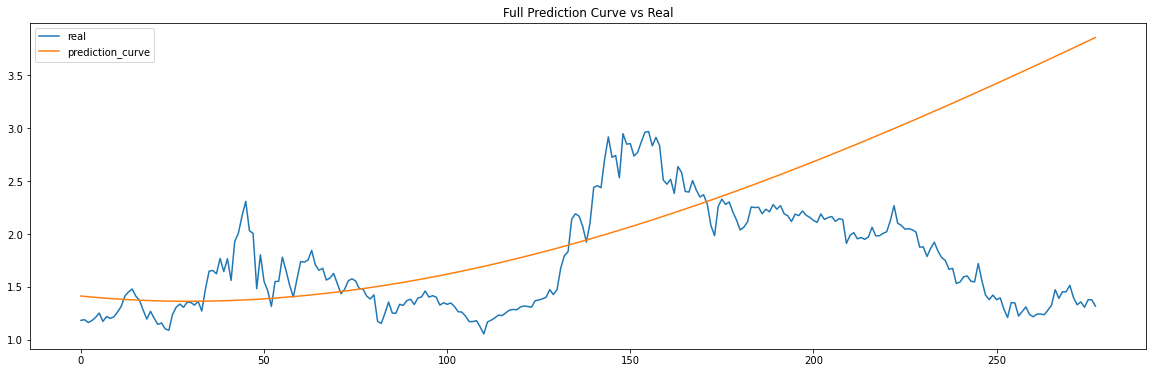

In [71]:
ada_prediction_curve = model_ada.predict(polynomial_features.fit_transform(df_ada.index.to_numpy()[:, None]))
plot_graph(title = 'Full Prediction Curve vs Real', real = df_ada['price'], prediction_curve = ada_prediction_curve)

---

<h3>Rolling Forecast</h3>

In [17]:
def rolling_forecast(df: pd.DataFrame, degree: int = 2, window: int = 7, test_ratio: float = 0.3) -> pd.DataFrame:

    polynomial_features = PolynomialFeatures(degree = degree)
    model = LinearRegression()
    x_test = df.index[ma.floor(df.shape[0] * (1 - test_ratio)):]
    result = pd.DataFrame(columns = ['date', 'pred', 'real'])

    for i in x_test:
        x_train = polynomial_features.fit_transform(df.index[i - window:i].to_numpy()[:, None])
        y_train = df['price'][i - window:i]

        model.fit(x_train, y_train)
        pred = model.predict(polynomial_features.fit_transform([[i]]))[0]
        result.loc[i] = {'date': df.loc[i]['date'],'pred': pred, 'real': df.loc[i]['price']}

    return result.set_index('date')

In [72]:
ada_rolling_1_7 = rolling_forecast(df_ada, degree = 1, window = 7)
ada_rolling_2_7 = rolling_forecast(df_ada, degree = 2, window = 7)
ada_rolling_1_14 = rolling_forecast(df_ada, degree = 2, window = 14)
ada_rolling_2_14 = rolling_forecast(df_ada, degree = 2, window = 14)

In [75]:
print('Degree 1 Window 7 MAPE:', MAPE(ada_rolling_1_7['pred'], ada_rolling_1_7['real']))
print('Degree 2 Window 7 MAPE:', MAPE(ada_rolling_2_7['pred'], ada_rolling_2_7['real']))
print('Degree 1 Window 14 MAPE:', MAPE(ada_rolling_1_14['pred'], ada_rolling_1_14['real']))
print('Degree 2 Window 14 MAPE:', MAPE(ada_rolling_2_14['pred'], ada_rolling_2_14['real']))

Degree 1 Window 7 MAPE: 0.03890907984694082
Degree 2 Window 7 MAPE: 0.051377842326672016
Degree 1 Window 14 MAPE: 0.04424358263191557
Degree 2 Window 14 MAPE: 0.04424358263191557


<p>As it turns out, it seems like using polynomial degree 1 or linear regression with a short time window, about 7 days, gives the best reults.</p>

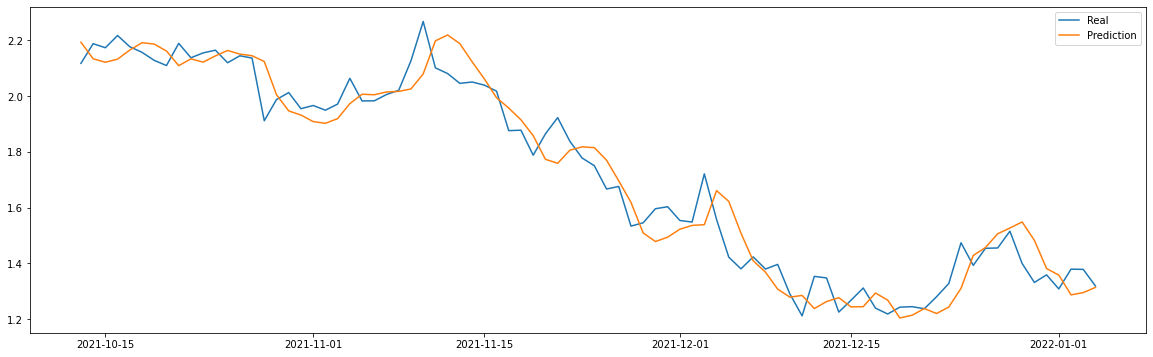

In [77]:
plot_graph(Real = ada_rolling_1_7['real'], Prediction = ada_rolling_1_7['pred'])

---

<h3>ETH</h3>

In [22]:
df_eth = get_csv('./data/ethereum.csv')

In [23]:
eth_rolling = rolling_forecast(df_eth, degree = 1)

0.04870844221890121


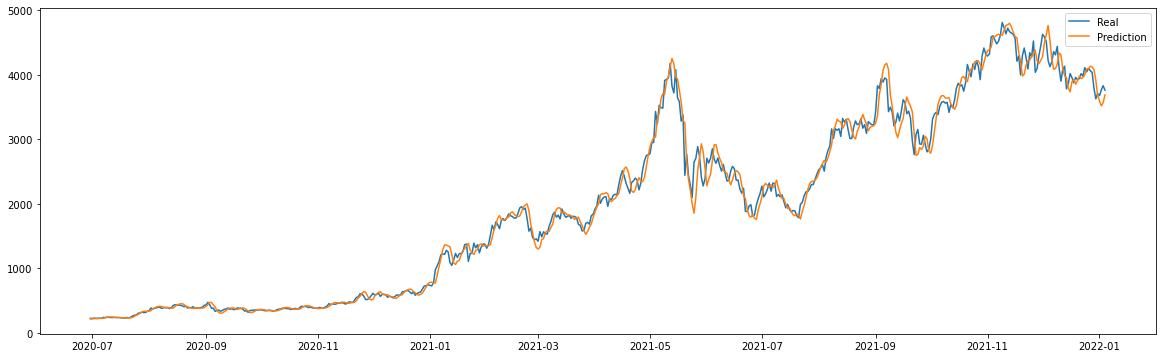

In [24]:
print(MAPE(eth_rolling['pred'], eth_rolling['real']))
plot_graph(Real = eth_rolling['real'], Prediction = eth_rolling['pred'])

---

<h3>DOGE</h3>

In [25]:
df_doge = get_csv('./data/dogecoin.csv')[775:].reset_index().drop(columns = ['index'])

In [26]:
doge_rolling = rolling_forecast(df_doge, degree = 1)

0.04467044118940917


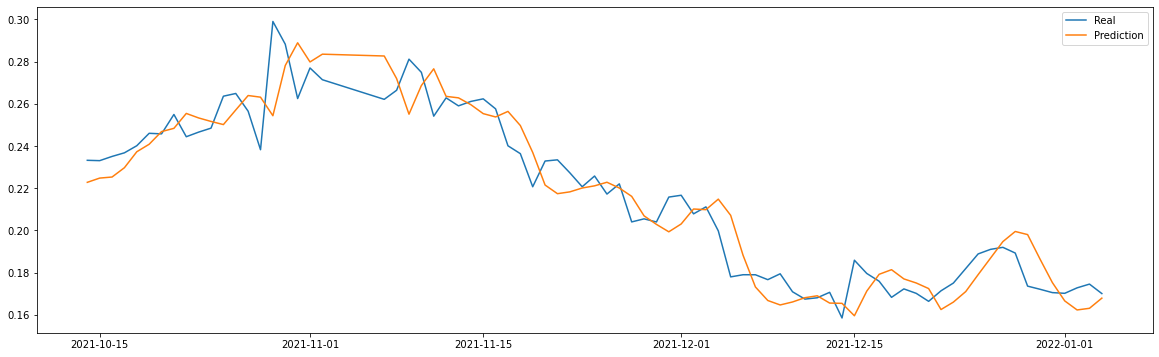

In [27]:
print(MAPE(doge_rolling['pred'], doge_rolling['real']))
plot_graph(Real = doge_rolling['real'], Prediction = doge_rolling['pred'])

---

<h3>SOL</h3>

In [28]:
df_sol = get_csv('./data/solana.csv')

In [29]:
sol_rolling = rolling_forecast(df_sol, degree = 1)

0.04682763333321861


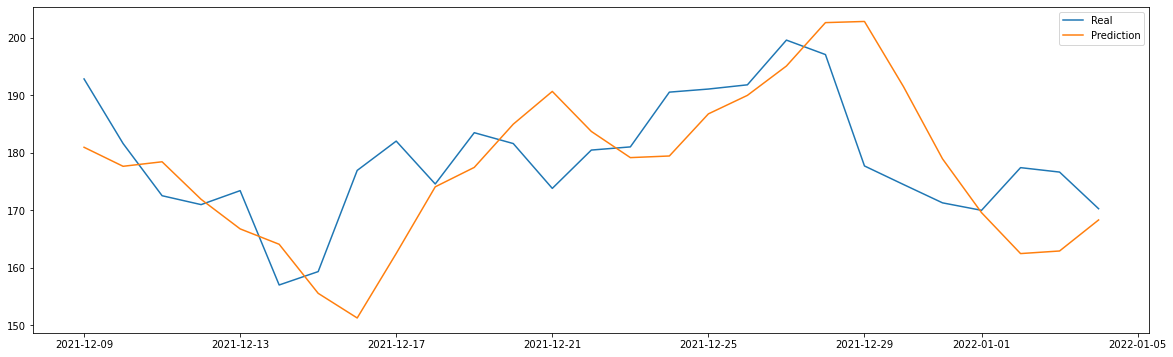

In [30]:
print(MAPE(sol_rolling['pred'], sol_rolling['real']))
plot_graph(Real = sol_rolling['real'], Prediction = sol_rolling['pred'])